In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

In [2]:
#télécharger les datasets
X_train = pd.read_csv("/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/X_train_update.csv") 
X_test = pd.read_csv("/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/X_test_update.csv") 
y_train = pd.read_csv("/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/Y_train_CVw08PX.csv")

In [3]:
#fusionner les training sets pour analyser les articles par classe
X_train = X_train.sort_values(by = 'Unnamed: 0', ascending = True)
y_train = y_train.sort_values(by = 'Unnamed: 0', ascending = True)
part2 = X_train[X_train.columns[3:]]
df = pd.concat([y_train,part2], axis=1)
df["image_name"] = "image_" + df.imageid.map(str)+ "_product_" + df.productid.map(str) + ".jpg"
df["image_name"] = df["image_name"].astype(str)
df['fullpath']= '/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/images/image_train/'+ df['image_name']
df.head()

,Unnamed: 0,prdtypecode,productid,imageid,image_name,fullpath
0,0,10,3804725264,1263597046,image_1263597046_product_3804725264.jpg,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...
1,1,2280,436067568,1008141237,image_1008141237_product_436067568.jpg,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...
2,2,50,201115110,938777978,image_938777978_product_201115110.jpg,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...
3,3,1280,50418756,457047496,image_457047496_product_50418756.jpg,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...
4,4,2705,278535884,1077757786,image_1077757786_product_278535884.jpg,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...


In [4]:
df['class'] = df['prdtypecode']

df = df.replace({'class': {10: 1, 2280:2,   50:3, 1280:4, 2705:5, 2522:6, 2582:7, 1560:8, 1281:9, 1920:10, 2403:11,
       1140:12, 2583:13, 1180:14, 1300:15, 2462:16, 1160:17, 2060:18,   40:19,   60:20, 1320:21, 1302:22,
       2220:23, 2905:24, 2585:25, 1940:26, 1301:0}})

In [5]:
data = df.drop(["Unnamed: 0","prdtypecode", "imageid", "image_name"], axis=1)
data.head()

,productid,fullpath,class
0,3804725264,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...,1
1,436067568,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...,2
2,201115110,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...,3
3,50418756,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...,4
4,278535884,/Users/ayseaylinkaya/Desktop/Datascientist/2 P...,5


In [6]:
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 123)

In [12]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

batch_size = 32
data_train["class"] = data_train["class"].astype(str)
data_test["class"] = data_test["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                           directory="",
                                                           x_col = "fullpath",
                                                           class_mode ="sparse",
                                                           target_size = (224 , 224),
                                                           zoom_range = [0.5,1.0],
                                                           batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                         directory="",
                                                         x_col = "fullpath",
                                                         class_mode ="sparse",
                                                         target_size = (224,224), 
                                                         batch_size = batch_size,
                                                         shuffle = False)

<ipython-input-12-56dd82ff4b0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["class"] = data_train["class"].astype(str)
<ipython-input-12-56dd82ff4b0e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["class"] = data_test["class"].astype(str)


Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [13]:
base_model = VGG16(weights='imagenet', include_top=False)

for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()

model.add(base_model) 

model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(rate=0.2))
model.add(Dense(27, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 27)               

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

my_callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True),
    ModelCheckpoint(filepath='/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/model_image.{epoch:02d}-{val_loss:.2f}.h5'),
]

In [15]:
history = model.fit_generator(generator=train_generator, 
                                epochs = 5,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data = test_generator,
                                validation_steps = len(data_test)//batch_size,
                                callbacks=my_callbacks)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2122/2122 [==============================] - 11312s 5s/step - loss: 2.1268 - acc: 0.4184 - val_loss: 1.5574 - val_acc: 0.5363
Epoch 2/5
2122/2122 [==============================] - 10596s 5s/step - loss: 1.5502 - acc: 0.5391 - val_loss: 1.4685 - val_acc: 0.5596
Epoch 3/5
2122/2122 [==============================] - 10404s 5s/step - loss: 1.4357 - acc: 0.5682 - val_loss: 1.4330 - val_acc: 0.5744
Epoch 4/5
2122/2122 [==============================] - 11395s 5s/step - loss: 1.3643 - acc: 0.5848 - val_loss: 1.4217 - val_acc: 0.5783
Epoch 5/5
2122/2122 [==============================] - 10962s 5s/step - loss: 1.2880 - acc: 0.6055 - val_loss: 1.4115 - val_acc: 0.5846


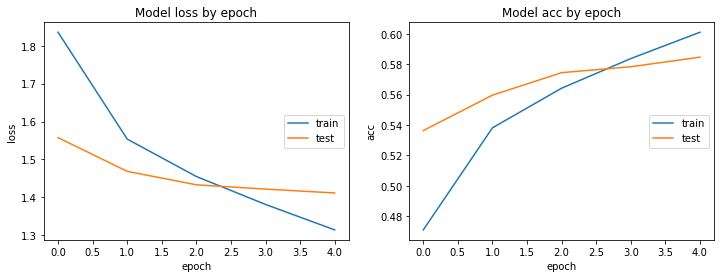

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
#model = load_model('/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/model_image.05-1.41.h5') 

In [19]:
from time import time
from sklearn import metrics

t0 = time()

test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                         directory="",
                                                         x_col = "fullpath",
                                                         class_mode ="categorical",
                                                         target_size = (224,224), 
                                                         batch_size = batch_size,
                                                         shuffle = False)

y_pred_proba = model.predict_generator(test_generator)
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

#y_test_class = data_test['class'].astype(int)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, y_pred_class))

df_tosave=pd.DataFrame(y_pred_proba)
path = '/Users/ayseaylinkaya/Desktop/Datascientist/2 Project Rakuten/'
df_tosave.to_csv(f'{path}/ypred_proba_Image_score_0_58.csv')

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Found 16984 validated image filenames belonging to 27 classes.


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.45      0.60      0.51       154
           1       0.52      0.37      0.44       601
           2       0.78      0.80      0.79       866
           3       0.59      0.60      0.60       979
           4       0.56      0.59      0.57       552
           5       0.74      0.85      0.79      2045
           6       0.37      0.25      0.30       139
           7       0.59      0.71      0.64      1006
           8       0.52      0.43      0.47       298
           9       0.83      0.90      0.86       791
          10       0.44      0.50      0.47      1060
          11       0.45      0.47      0.46       475
          12       0.58      0.72      0.64       964
          13       0.60      0.61      0.61       176
          14       0.37      0.47      0.41       635
          15       0.56      0.33      0.41       505
          16       0.64      0.28      0.39       151
          17       0.52    

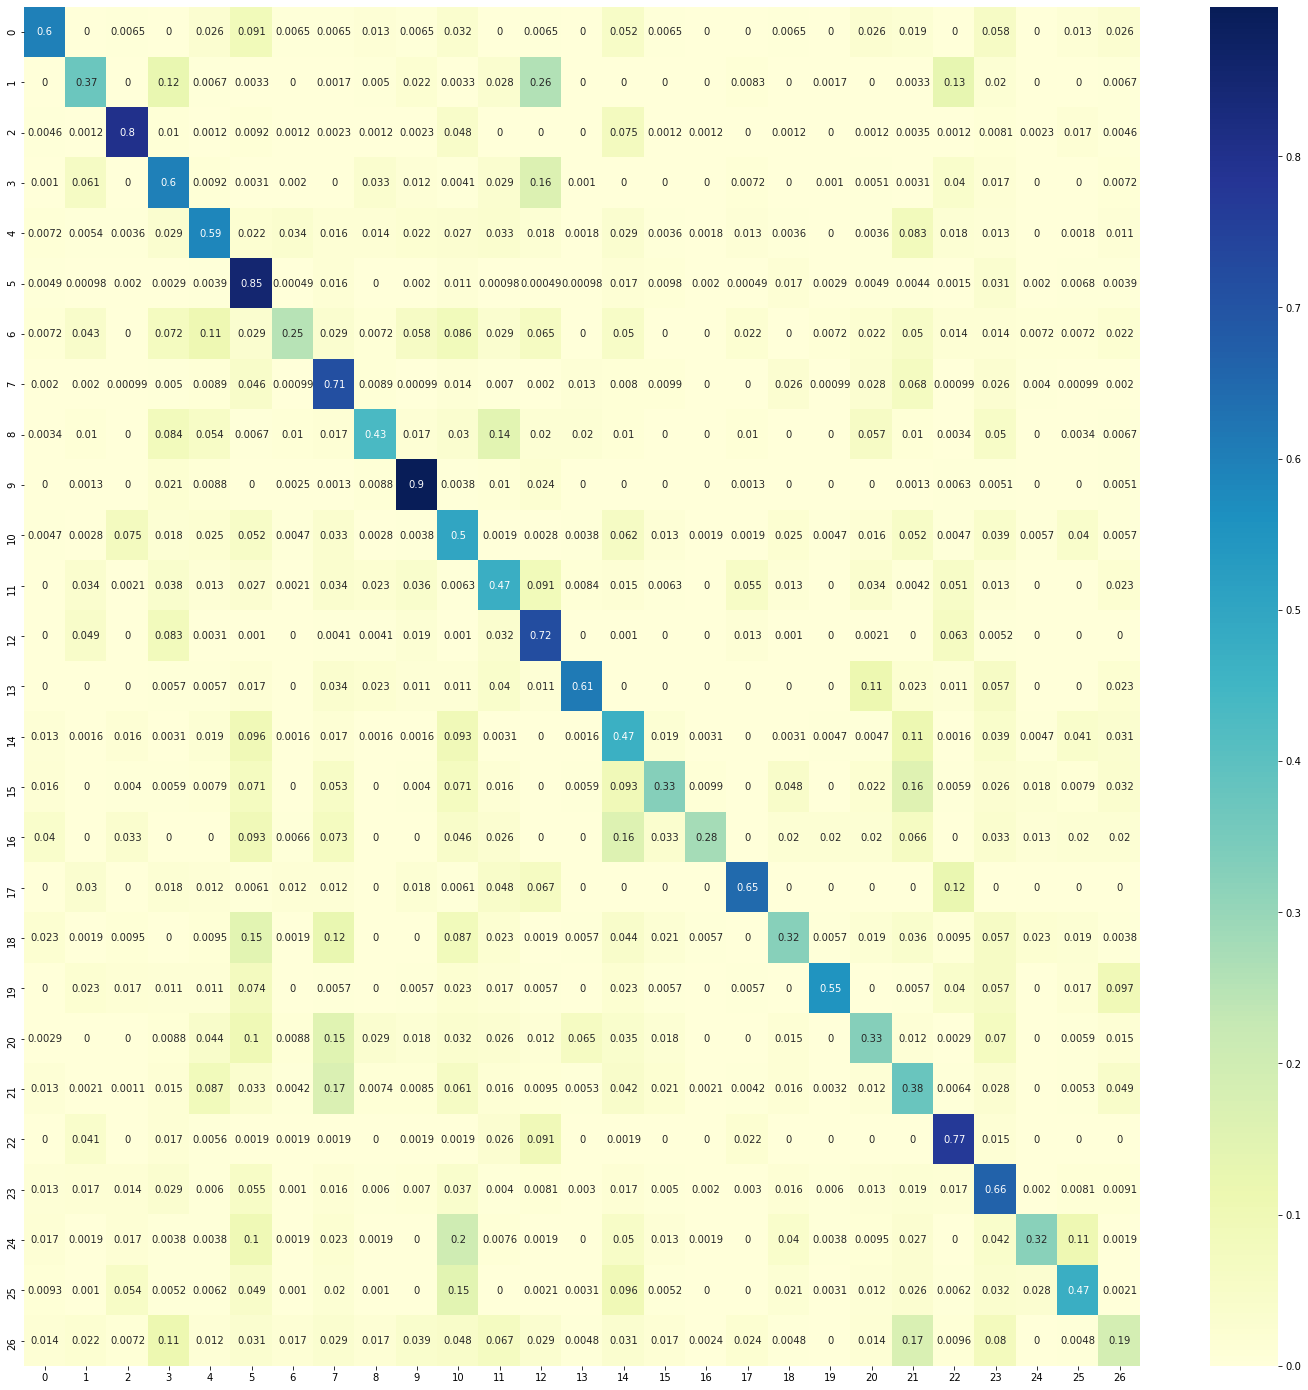

In [20]:
cmn = metrics.confusion_matrix(y_test_class, y_pred_class, normalize = 'true')
plt.figure(figsize=(25,25))
sns.heatmap(cmn,  annot=True, cmap="YlGnBu");